Бейзлайн. Можно использовать как шаблон.

# Импорты и библиотеки

In [3]:
!pip install -q polars tqdm scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [301]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


def dataframe_to_html(df: pl.DataFrame, columns: list) -> str:
    """
    Convert a Polars DataFrame to an HTML table with specified columns.

    Args:
        df: Polars DataFrame containing the data.
        columns: List of column names to include in the HTML table.

    Returns:
        str: HTML string representing the table.
    """
    html = ["<table border='1'>"]

    html.append("<tr>")
    for col in columns:
        html.append(f"<th>{col}</th>")
    html.append("</tr>")

    for row in df.iter_rows(named=True):
        html.append("<tr>")
        for col in columns:
            value = row[col]
            if col == "image_url":
                html.append(f"<td><img src='{value}' width='100' /></td>")
            else:
                html.append(f"<td>{value}</td>")
        html.append("</tr>")

    html.append("</table>")
    return "\n".join(html)


# Посмотрим на данные 

Более подробный обзор данных можно (но не обязательно нужно) найти [по ссылке](https://github.com/MengtingWan/goodreads/tree/master?tab=readme-ov-file).

In [302]:
data_folder = "data/"

**Train**
* `user_id` - уникальный идентификатор пользователя
* `item_id` - уникальный идентификатор книги
* `is_read` - прочитал ли пользователь книгу или только добавил в избранное
* `rating` - рейтинг, поставленный книге пользователем (0, если пользователь не оставил рейтинг)
* `date_added` - дата добавления книги в избранное

In [303]:
train = pl.read_parquet(data_folder + "train.pq")
print("Train:")
print(train.shape)
display(train.head(5))

Train:
(11971437, 5)


user_id,item_id,is_read,rating,date_added
str,i64,bool,i64,datetime[μs]
"""90998a29029ecb1fbeedaff2b71752…",8473,false,0,2014-05-15 12:51:13
"""90998a29029ecb1fbeedaff2b71752…",20060,false,0,2014-05-15 12:51:14
"""90998a29029ecb1fbeedaff2b71752…",8354,false,0,2014-05-15 12:51:17
"""90998a29029ecb1fbeedaff2b71752…",11575,false,0,2014-05-15 12:51:19
"""90998a29029ecb1fbeedaff2b71752…",11861,false,0,2014-05-15 12:51:20


**Test**
* `user_id` - уникальный идентификатор пользователя
* `item_id` - список уникальных идентификатор книг, с которыми пользователь провзаимодействовал в течение тестового периода, отсортированный по релевантности 

In [304]:
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))
print("Test:")
print(test.shape)
display(test.head(5))

Test:
(185828, 2)


user_id,item_id
str,list[i64]
"""00000377eea48021d3002730d56aca…",[13252]
"""00009ab2ed8cbfceda5a59da409663…",[2328]
"""00009e46d18f223a82b22da38586b6…","[28636, 30197]"
"""0001085188e302fc6b2568de45a5f5…","[2159, 2969, … 33630]"
"""00014c578111090720e20f5705eba0…","[45, 3513, … 33273]"


In [305]:
# в тесте нет холодных пользователей
len(set(test["user_id"].to_list()) - set(train["user_id"].to_list()))

0

In [306]:
# но есть холодные айтемы
len(set(test_exploded["item_id"].to_list()) - set(train["item_id"].to_list()))

1775

**Books**
* `item_id` - уникальный идентификатор книги
* `series` - если книга является частью серии, то это список идентификаторов серии
* `tags` - список проставленных пользователями тегов
* `title` - название книги
* `description` - описание книги
* `url` - ссылка на книгу на Goodreads
* `image_url` - обложка книги
* `authors` - список авторов книги в формате пар (автор, роль)

In [307]:
books = pl.read_parquet(data_folder + "books.pq")
print("Books:")
print(books.shape)
display(books.head(5))

Books:
(34322, 8)


item_id,series,tags,title,description,url,image_url,authors
i64,list[str],list[str],str,str,str,str,list[struct[2]]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]"


Взглянем на пару книг

In [308]:
HTML(dataframe_to_html(books.sample(5), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
12062,Deadgirl: Ghostlight,"Transformed into a ""phantom"" by her own titanic will to live, Lucy must feed on the essence, memories, and emotions of others to keep herself solid. After defeating her Grim Reaper and learning that she could survive without hurting people, Lucy thought the madness was finally over. Her cravings for essence under control, Lucy tries to live a normal life. Apparently you have to be alive for that to work, though, as Lucy learns that one of her friends is more than she appears. She insists that Lucy, with her ghostly abilities and tentative immortality, can join her in the fight to help those in need. Thrust into the role of teenage savior, Lucy Day finds herself battling a pack of voyeuristic serial killers, a mysterious and deadly wraith, and the idea that she might actually have to start dating again sometime this century.",
7255,"Ritual (Vampire Beach, #3)","The A-list bites.Jason Freeman has gotten used to the fact that beneath its glamorous surface, DeVere Heights is full of unexpected secrets. And vampires. Then just when he thinks he's golden, he's attacked. With a crossbow. At first the attention Jason gets from his crush, Sienna, makes the wound almost worthwhile -- especially after she breaks up with Brad. But the crossbow-wielding lunatic isn't finished, and his next victim is found dead with a bolt through the heart. As tensions rise at DeVere High, suspicions about the attacker point to pretty much anyone. There's something cold and hard in Brad's eyes-the look of a killer? Nah....",
13378,"Loose Lips (The Show, #2)",,
32274,"Point Guard (Home Team, #3)",,
15701,Fourteen,"High school is hard enough when you do fit in, but if you don't look a certain way or have the right friends, you'd better hope you grow a thick skin to defend yourself from the ones that do. Arianna Weller and Evan Drake are worlds apart, moving in different circles until they are forced together for a science fair project. Putting aside their differences from the past is not easy for either of them, but can they do it long enough to realize that they're not that different after all?",


In [309]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


# Пайплайн для экспериментов

## Валидация

Будем смотреть на две метрики качества: **NDCG** и **Recall**.  
Обе метрики измеряются до какой-то позиции (@k), зафиксируем k=10. То есть мы оцениваем 10 самых подходящих пользователю айтемов по мнению модели.  

* **NDCG** показывает, как модель справляется с задачей ранжирования, то есть ставит более релевантные айтемы выше менее релевантных
* **Recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

Также будем смотреть на метрику разнообразия **Coverage**.
* **Coverage** показывает долю порекомендованных айтемов от всего каталога. Низкое значение метрики свидетельствует о том, что модель рекомендует всем одно и то же

Для всех метрик лучше та, которая как можно ближе к **1.0**


In [310]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog


def evaluate_recommender(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
) -> dict:
    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]
    result = {}
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.clone()
    
    for metric in metrics:
        result_df = result_df.with_columns(
            metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
        )
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)
    
    return result

Посмотрим, какие метрики показала бы идеальная рекомендательная система.

Кстати, как думаете, почему recall=0.8, а не 1.0? Здесь нет ошибки.

In [311]:
%%time 
evaluate_recommender(df=test.with_columns(item_id_=pl.col("item_id")), model_preds_col="item_id_", ground_truth_col="item_id")

CPU times: user 7.34 s, sys: 563 ms, total: 7.91 s
Wall time: 7.14 s


{'ndcg@10': 1.0, 'recall@10': 0.812, 'coverage': 0.797}

Можно добавить и другие метрики качества, такие как MAP, HitRate, MRR, Precision, а также метрики разнообразия, например Diversity. Также полезно бывает варьировать k.

Интересно почитать следующий [цикл статей](https://habr.com/ru/companies/ods/articles/750974/), где рассказывается о том, как оценивать рекомендательные системы, и почему оффлайн-метрики могут идти вразрез с бизнес-метриками.

## Базовый класс модели

Будет удобно проводить эксперименты, используя единый интерфейс.

In [312]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pl.DataFrame, **kwargs) -> None:
        # реализация может быть любой, никаких ограничений
        # не забудьте про self.trained = True
        self.trained = True

    @abstractmethod
    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращаться список массивов из item_id, которые есть в `books`, чтобы корректно работал подсчет метрик
        pass

## Бейзлайны

### Random

Начнем с sanity checking бейзлайна в виде случайных рекомендаций. Ожидаемо получаем плохие метрики качества.

In [313]:
class RandomRecommender:
    def __init__(self):
        self.trained = False
        self.item_ids = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        # сохраняем уникальные айтемы
        self.item_ids = df[item_id_col].unique().to_numpy()
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        # случайно выбираем `topn` айтемов
        preds = []
        for _ in tqdm(range(len(df))):
            preds.append(np.random.choice(self.item_ids, size=topn, replace=False))
        return preds


random_rec = RandomRecommender()
random_rec.fit(books)  # выбираем из всего доступного каталога
test = test.with_columns(
    random_recs=pl.Series(random_rec.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="random_recs")

  0%|          | 0/185828 [00:00<?, ?it/s]

shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ random_recs             │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ array[i64, 10]          │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [27547, 4970, … 3248]   │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [19675, 21568, … 3847]  │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [30534, 9626, … 688]    │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [10852, 21325, … 29841] │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [19799, 14240, … 11794] │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘


{'ndcg@10': 0.001, 'recall@10': 0.0, 'coverage': 1.0}

### TopPopular

Попробуем классический алгоритм, который зачастую бывает сложно победить по оффлайн-метрикам. Он выбирает самые часто встречающиеся в тренировочных данных айтемы и рекомендует всем одно и то же.

In [314]:
class TopPopular:
    def __init__(self):
        self.trained = False
        self.recommendations = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = (
            df.lazy()
            .group_by(item_id_col)
            .agg(count=pl.len())
            .sort("count", descending=True)
            .collect()
            [item_id_col]
            .to_numpy()
        )
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train)
test = test.with_columns(
    toppopular_recs=pl.Series(toppop.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="toppopular_recs")

shape: (5, 4)
┌────────────────────────┬───────────────────────┬────────────────────────┬────────────────────────┐
│ user_id                ┆ item_id               ┆ random_recs            ┆ toppopular_recs        │
│ ---                    ┆ ---                   ┆ ---                    ┆ ---                    │
│ str                    ┆ list[i64]             ┆ array[i64, 10]         ┆ array[i64, 10]         │
╞════════════════════════╪═══════════════════════╪════════════════════════╪════════════════════════╡
│ 00000377eea48021d30027 ┆ [13252]               ┆ [27547, 4970, … 3248]  ┆ [4058, 15514, … 13159] │
│ 30d56aca…              ┆                       ┆                        ┆                        │
│ 00009ab2ed8cbfceda5a59 ┆ [2328]                ┆ [19675, 21568, … 3847] ┆ [4058, 15514, … 13159] │
│ da409663…              ┆                       ┆                        ┆                        │
│ 00009e46d18f223a82b22d ┆ [28636, 30197]        ┆ [30534, 9626, … 688]   ┆ [

{'ndcg@10': 0.033, 'recall@10': 0.033, 'coverage': 0.0}

Метрики качества выросли! Интересно, cильно ли изменятся значения, если уменьшить k?

In [315]:
evaluate_recommender(df=test, model_preds_col="toppopular_recs", k=5)

{'ndcg@5': 0.028, 'recall@5': 0.019, 'coverage': 0.0}

Посмотрим на то, что же рекомендуется всем пользователям.

In [316]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test["toppopular_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
118,"Cinder (The Lunar Chronicles, #1)","Sixteen-year-old Cinder is considered a technological mistake by most of society and a burden by her stepmother. Being cyborg does have its benefits, though: Cinder's brain interference has given her an uncanny ability to fix things (robots, hovers, her own malfunctioning parts), making her the best mechanic in New Beijing. This reputation brings Prince Kai himself to her weekly market booth, needing her to repair a broken android before the annual ball. He jokingly calls it ""a matter of national security,"" but Cinder suspects it's more serious than he's letting on. Although eager to impress the prince, Cinder's intentions are derailed when her younger stepsister, and only human friend, is infected with the fatal plague that's been devastating Earth for a decade. Blaming Cinder for her daughter's illness, Cinder's stepmother volunteers her body for plague research, an ""honor"" that no one has survived. But it doesn't take long for the scientists to discover something unusual about their new guinea pig. Something others would kill for.",
4058,The Fault in Our Stars,"Despite the tumour-shrinking medical miracle that has bought her a few years, Hazel has never been anything but terminal, her final chapter inscribed upon diagnosis. But when a gorgeous plot twist named Augustus Waters suddenly appears at Cancer Kid Support Group, Hazel's story is about to be completely rewritten. Insightful, bold, irreverent, and raw, The Fault in Our Stars is award-winning author John Green's most ambitious and heartbreaking work yet, brilliantly exploring the funny, thrilling, and tragic business of being alive and in love. John Green is the best-selling author of Looking for Alaska; An Abundance of Katherines;Paper Towns; Will Grayson, Will Grayson. The reviewers say: 'A novel of life and death and the people caught in between, The Fault in Our Stars is John Green at his best. You laugh, you cry, and then you come back for more.' Markus Zusak, bestselling and Printz Honor-winning author of The Book Thief 'An electric portrait of young people who learn to live life with one foot in the grave. Filled with staccato bursts of humor and tragedy, The Fault in Our Stars takes a spin on universal themes-Will I be loved? Will I be remembered? Will I leave a mark on this world?-by dramatically raising the stakes for the characters who are asking.' Jodi Picoult, bestselling author of My Sister's Keeper and Sing You Home 'John Green writes incredible, honest truths about the secret, weird hearts of human beings. He makes me laugh and gasp at the beauty of a sentence or the twist of a tale. He is one of the best writers alive and I am seething with envy of his talent.' E. Lockhart, National Book Award Finalist and Printz Honor-winning author of The Disreputable History of Frankie Landau Banks and The Boyfriend List",
13159,"The Maze Runner (Maze Runner, #1)","Perfect for fans of Divergentand The Hunger Games,this special movie tie-in edition of the first book in the #1 New York Timesbestselling Maze Runner series, The Maze Runner, features an eight-page full-color insert with photos from the film and an exclusive fan sticker. The first and second books, The Maze Runnerand The Scorch Trials, are now major motion pictures featuring the star of MTV's Teen Wolf,Dylan O'Brien, as Thomas; Kaya Scodelario as Teresa; Aml Ameen as Alby; Will Poulter as Gally; and Thomas Brodie-Sangster as Newt! And look for James Dashner's newest novels, The Eye of Mindsand The Rule of Thoughts, the first two books in the Mortality Doctrine series. Nice to meet ya, shank. Welcome to the Glade. Outside the towering stone walls that surround the Glade is a limitless, ever-changing maze. It's the only way out--and no one's ever made it through alive. Everything is going to change. Then a girl arrives. The first girl ever. And the message she delivers is terrifying. Remember. Survive. Run. Praise for the Maze

Вспомним про наличие "холодных" книг в тестовых данных. Правда ли, что TopPopular никогда не порекомендует такие книги? А что насчет книг, которые пользователь уже прочитал?

### ItemkNN

Попробуем реализовать более персонализированный подход - будем рекомендовать пользователю книги, похожие на те, что понравились ему ранее. Для этого закодируем каждую книгу как набор ключевых слов.

In [317]:
tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

vectorizer = CountVectorizer(min_df=0.2, max_df=0.8, max_features=32)
X = vectorizer.fit_transform(tags_as_strings)
embeddings = normalize(X.toarray()).tolist()

books = books.with_columns(
    pl.Series("embedding", embeddings)
)
display(books.head())

item_id,series,tags,title,description,url,image_url,authors,embedding
i64,list[str],list[str],str,str,str,str,list[struct[2]],list[f64]
0,[null],"[""e-book"", ""young-adult"", … ""y-a""]","""Hallie Hath No Fury . . .""","""There are two sides to every s…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""1879494"",""""}]","[0.0, 0.585206, … 0.0]"
1,"[""149079""]","[""primary"", ""melissa-j--morgan"", … ""fiction""]","""Hide and Shriek: Super Special…","""The girls go on an overnight a…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""21740"",""""}]","[0.0, 0.0, … 0.199007]"
2,[null],"[""friendship"", ""middle-reader"", … ""my-library""]","""Dear Mom, You're Ruining My Li…","""Samantha Slayton worries about…","""https://www.goodreads.com/book…","""https://s.gr-assets.com/assets…","[{""18946"",""""}]","[0.0, 0.27735, … 0.0]"
3,"[""151088""]","[""summer-2017"", ""bullying"", … ""re-read""]","""Bratfest at Tiffany's (Clique …","""Massie Block: The Briarwood bo…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""4605"",""""}]","[0.0, 0.0, … 0.0]"
4,"[""812067""]","[""rosemary-vernon"", ""young-adult"", … ""to-read""]","""Questions of Love (Sweet Dream…","""When Sammi Edwards is chosen t…","""https://www.goodreads.com/book…","""https://images.gr-assets.com/b…","[{""792676"",""""}]","[0.0, 0.2, … 0.0]"


In [318]:
class ItemkNN:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id"
    ) -> None:
        self.items_embeddings = np.array(items_df["embedding"].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, "embedding"]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data["embedding"].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data["embedding"].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions


item_knn = ItemkNN()
item_knn.fit(train, books)
test = test.with_columns(
    item_knn_recs=pl.Series(item_knn.predict(test))
)
print(test.head())
evaluate_recommender(df=test, model_preds_col="item_knn_recs")

  0%|          | 0/38 [00:00<?, ?it/s]

shape: (5, 5)
┌───────────────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┐
│ user_id           ┆ item_id           ┆ random_recs       ┆ toppopular_recs   ┆ item_knn_recs    │
│ ---               ┆ ---               ┆ ---               ┆ ---               ┆ ---              │
│ str               ┆ list[i64]         ┆ array[i64, 10]    ┆ array[i64, 10]    ┆ list[i64]        │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ 00000377eea48021d ┆ [13252]           ┆ [27547, 4970, …   ┆ [4058, 15514, …   ┆ [4493, 26690, …  │
│ 3002730d56aca…    ┆                   ┆ 3248]             ┆ 13159]            ┆ 31641]           │
│ 00009ab2ed8cbfced ┆ [2328]            ┆ [19675, 21568, …  ┆ [4058, 15514, …   ┆ [16282, 986, …   │
│ a5a59da409663…    ┆                   ┆ 3847]             ┆ 13159]            ┆ 21243]           │
│ 00009e46d18f223a8 ┆ [28636, 30197]    ┆ [30534, 9626, …   ┆ [4058, 15514, …

{'ndcg@10': 0.007, 'recall@10': 0.008, 'coverage': 0.764}

Лучше, чем случайность, но хуже, чем топ популярных. А хуже ли? Посмотрим некоторые подборки рекомендаций.

In [323]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
570,A Million Miles Away,"Twin sisters Kelsey and Michelle Maxfield look identical -- but they couldn't be more different. Kelsey is the captain of the dance team and loves her cute college boyfriend, Davis. Michelle is a free-spirited artist and flits from one guy to the next, the latest a soldier recently deployed to Afghanistan. Despite their differences, Kelsey and Michelle can't live without each other--until, in an instant, everything changes. When Michelle dies in a car crash, Kelsey is left without her other half. As the only one who knows about her sister's boyfriend, Peter, Kelsey takes it upon herself to find him and tell him what happened to Michelle. But when she finally connects with Peter online, he thinks that Kelsey isMichelle and says that seeing her is the one thing keeping him alive. Caught up in the moment, Kelsey can't bear to break his heart with the truth, so she lets Peter believe that she is Michelle. Kelsey keeps up the act, pretending to be her sister, and soon she can't deny that she's falling, hard, for the one boy she shouldn't want. Lara Avery delivers a breathtaking story of love and loss that is guaranteed to sweep you off your feet.",
2643,Where the Road Takes Me,"Listening time 8 hours 51 minutes Chloe has one plan for the future, and one plan only: the road. She's made a promise to herself: don't let anyone in, and don't let anyone love her. She's learned the hard way what happens if she breaks her rules. So she's focused on being invisible and waiting until she can set out on the road--her dream of freedom, at least for a little while. Blake Hunter is a basketball star who has it all--everything about him looks perfect to those on the other side of his protective walls. He can't let anyone see the shattered pieces behind the flawless facade or else all his hopes and dreams will disappear. One dark night throws Chloe and Blake together, changing everything for Blake. For Chloe, nothing changes: she has the road, and she's focused on it. But when the so-called perfect boy starts to notice the invisible girl, they discover that sometimes with love, no one knows where the road may lead.",
2715,"Where the Road Takes Me (The Road, #1)","Chloe has one plan for the future, and one plan only: the road. She's made a promise to herself: don't let anyone in, and don't let anyone love her. She's learned the hard way what happens if she breaks her rules. So she's focused on being invisible and waiting until she can set out on the road--her dream of freedom, at least for a little while. Blake Hunter is a basketball star who has it all--everything about him looks perfect to those on the other side of his protective walls. He can't let anyone see the shattered pieces behind the flawless facade or else all his hopes and dreams will disappear. One dark night throws Chloe and Blake together, changing everything for Blake. For Chloe, nothing changes: she has the road, and she's focused on it. But when the so-called perfect boy starts to notice the invisible girl, they discover that sometimes with love, no one knows where the road may lead.",
6659,Kissing in America,"Acclaimed writer Margo Rabb's Kissing in Americais ""a wonderful novel about friendship, love, travel, life, hope, poetry, intelligence, and the inner lives of girls,"" raves internationallybestselling author Elizabeth Gilbert (Eat, Pray, Love). In the two years since her father died, sixteen-year-old Eva has found comfort in reading romance novels--118 of them, to be exact--to dull the pain of her loss that's still so present. Her romantic fantasies become a reality when she meets Will, who can relate to Eva's grief. Unfortunately, after Eva falls head-over-heels for him, he picks up and moves to California with barely any warning. Not wanting to lose the only person who has been able to pull her out of sadness--and, perhaps, her first shot at real love--Eva and her best friend, Annie, concoct a plan to travel t

In [326]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
2279,Insurgent,"One choice can transform you--or it can destroy you. But every choice has consequences, and as unrest surges in the factions all around her, Tris Prior must continue trying to save those she loves - and herself - while grappling with haunting questions of grief and forgiveness, identity and loyalty, politics and love. Tris's initiation day should have been marked by celebration and victory with her chosen faction; instead, the day ended with unspeakable horrors. War now looms as conflict between the factions and their ideologies grows. And in times of war, sides must be chosen, secrets will emerge, and choices will become even more irrevocable - and even more powerful. Transformed by her own decisions but also by haunting grief and guilt, radical new discoveries, and shifting relationships, Tris must fully embrace her Divergence, even if she does not know what she may lose by doing so. New York Timesbestselling author Veronica Roth's much-anticipated second book of the dystopian DIVERGENT series is another intoxicating thrill ride of a story, rich with hallmark twists, heartbreaks, romance, and powerful insights about human nature.",
3688,"Delirium (Delirium, #1)","Lena Haloway is content in her safe, government-managed society. She feels (mostly) relaxed about the future in which her husband and career will be decided, and looks forward to turning 18, when she'll be cured of deliria, a.k.a. love. She tries not to think about her mother's suicide (her last words to Lena were a forbidden ""I love you"") or the supposed ""Invalid"" community made up of the uncured just beyond her Portland, Maine, border. There's no real point--she believes her government knows how to best protect its people, and should do so at any cost. But 95 days before her cure, Lena meets Alex, a confident and mysterious young man who makes her heart flutter and her skin turn red-hot. As their romance blossoms, Lena begins to doubt the intentions of those in power, and fears that her world will turn gray should she submit to the procedure. In this powerful and beautifully written novel, Lauren Oliver, the bestselling author of Before I Fall, throws readers into a tightly controlled society where options don't exist, and shows not only the lengths one will go for a chance at freedom, but also the true meaning of sacrifice. --Jessica Schein",
4595,"Allegiant (Divergent, #3)","What if your whole world was a lie? The thrillingly dark conclusion to the No. 1 New York Times bestselling DIVERGENT trilogy. DIVERGENT - a major motion picture in 2014. What if a single revelation - like a single choice - changed everything? What if love and loyalty made you do things you never expected? The faction-based society that Tris Prior once believed in is shattered - fractured by violence and power struggles and scarred by loss and betrayal. So when offered a chance to explore the world past the limits she's known, Tris is ready. Perhaps beyond the fence, she and Tobias will find a simple new life together, free from complicated lies, tangled loyalties, and painful memories. But Tris's new reality is even more alarming than the one she left behind. Old discoveries are quickly rendered meaningless. Explosive new truths change the hearts of those she loves. And once again, Tris must battle to comprehend the complexities of human nature - and of herself - while facing impossible choices about courage, allegiance, sacrifice and love. Told from a riveting dual perspective, Allegiant, by #1 New York Times best-selling author Veronica Roth, brings the Divergent series to a powerful conclusion while revealing the secrets of the dystopian world that has captivated millions of readers in Divergent and Insurgent.",
7320,"Allegiant (Divergent, #3) الوفية","The faction-based society that Tris Prior once believed in is shattered - fractured by violence and power struggles and scarred by loss and betrayal. So when offered a chance to explo

In [324]:
HTML(dataframe_to_html(books.filter(pl.col("item_id").is_in(test.sample(1)["item_knn_recs"][0].to_list())), ["item_id", "title", "description", "image_url"]))

item_id,title,description,image_url
2839,Five Summers,"Bittersweet, funny, and achingly honest,Five Summersis a story of friendship, love, and growing up that is perfect for fans of Ann Brashare's The Sisterhood of the Traveling Pants and Judy Blume's Summer Sisters. Four best friends, five summers of camp memories Emma, Skylar, Jo, and Maddie have all come back to camp for a weekend of tipsy canoe trips to the island, midnight skinny dipping in the lake, and an epic game of capture the flag--boys versus girls. But the weekend isn't quite as sunwashed as they'd imagined as the memories come flooding back. . . . The summer we were nine:Emma was branded ""Skylar's friend Emma"" by the infamous Adam Loring . . . The summer we were ten:Maddie realized she was too far into her lies to think about telling the truth . . . The summer we were eleven:Johanna totally freaked out during her first game of Spin the Bottle . . . The summer we were twelve:Skylar's love letters from her boyfriend back home were exciting to all of us--except Skylar . . . Our last summer together:Emma and Adam almost kissed. Jo found out Maddie's secret. Skylar did something unthinkable . . . and whether we knew it then or not, five summers of friendship began to fall apart. A young adult book with a friendship story that will last long after the last s'more is gone.",
4437,An Unstill Life,"UNFORTUNATELY, DUE TO THE CLOSURE OF MUSA PUBLISHING, THIS BOOK IS CURRENTLY OUT OF PRINT. Things at home are rough for fifteen-year-old Livvie Quinn. Jules, her beloved older sister is sick again after being cancer free for almost ten years. Her mom becomes more frantic and unapproachable every day. School isn't much better. Just when she needs them most, her closest friends get boyfriends and have little time for Livvie - except to set her up on a series of disastrous blind dates. Livvie seeks refuge in the art room and finds Bianca, the school 'freak'. Free-spirited and confident, Bianca is everything Livvie isn't. Shaken by her mom's desperation, her sister's deteriorating condition, and abandoned by her friends, Livvie finds comfort and an attraction she never felt before with Bianca. When their relationship is discovered, Livvie and Bianca become victims of persecution and bullying. School authorities won't help and even forbid the pair to attend the Winter Formal as a couple. If Livvie defies them and goes, she risks expulsion and further ridicule from her classmates. At home, her mother's behavior escalates to new levels of crazy and Jules is begging for help to end the pain once and for all. While searching for the strength to make her life her own, Livvie must decide how far she's willing to go for the people she loves.",
11455,The Romantics,"Perfect for fans of Lauren Myracle and Rainbow Rowell, The Romantics will charm readers of all ages. Gael Brennan is about to have his heart broken when his first big relationship crumbles on the heels of his parents' painful separation. Love intervenes with the intention of setting things right--but she doesn't anticipate the intrusion of her dreaded nemesis: the Rebound. Love's plans for Gael are sidetracked by Cara, Gael's hot-sauce-wielding ""dream girl."" The more Love meddles, the further Gael drifts from the one girl who can help him mend his heart. Soon Love starts breaking all her own rules--and in order to set Gael's fate back on course, she has to make some tough decisions about what it means to truly care.",
16558,Starting From Here,"Sixteen-year-old Colby Bingham's heart has been broken too many times. Her mother has been dead for almost two years, her truck driver father is always away, her almost girlfriend just dumped her for a guy, and now she's failing chemistry. When a stray dog lands literally at her feet, bleeding and broken on a busy road, it seems like the Universe has it in for Colby. But the incident also knocks a chink in the walls she's built around her heart. Against her better judgment, she decides 

Выглядит достаточно персонализированно. Но, кажется, на десяток "наиболее похожих" приходятся скорее разные издания одной книги, нежели различные книги, которые часто читают вместе. 

#### Немного EDA

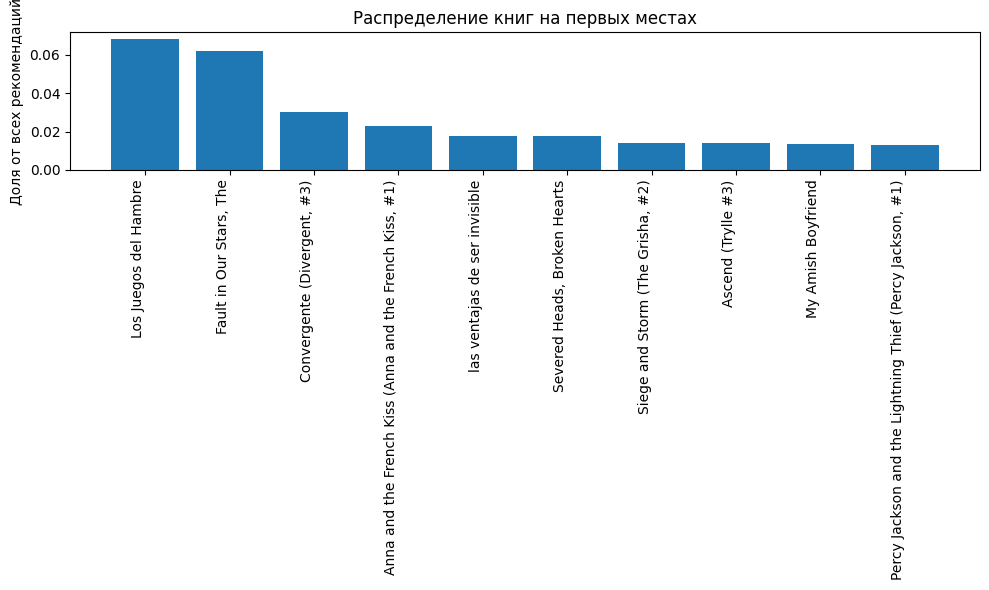

In [327]:
first_items = (
    pl.DataFrame({
        "item_id": test["item_knn_recs"].list.first()
    })
    .join(
        books.select("item_id", "title"),
        on="item_id",
        how="left"
    )
    .group_by("title")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .with_columns(
        (pl.col("count") / pl.col("count").sum()).alias("proportion")
    )
)

top_10 = first_items.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_10["title"].to_list(), top_10["proportion"].to_list())
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение книг на первых местах")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

Кстати, а может ли такой алгоритм порекомендовать "холодные" айтемы?